# Installation

In [3]:
%load_ext autoreload

In [4]:
%pip uninstall -y tempo_embeddings
%pip install -e ..

Found existing installation: tempo_embeddings 0.0.1
Uninstalling tempo_embeddings-0.0.1:
  Successfully uninstalled tempo_embeddings-0.0.1
Note: you may need to restart the kernel to use updated packages.
Obtaining file:///Users/carstenschnober/Documents/SemanticsOfSustainability/workspace/tempo-embeddings
  Installing build dependencies ... done
  Checking if build backend supports build_editable ... done
  Getting requirements to build editable ... done
  Preparing editable metadata (pyproject.toml) ... done
  Building editable for tempo_embeddings (pyproject.toml) ... done
  Created wheel for tempo_embeddings: filename=tempo_embeddings-0.0.1-0.editable-py3-none-any.whl size=9609 sha256=4a29aebfe28fcfd8797b9e3de5f92c40c13d9f4068b8ba997b65b69dfa49f459
  Stored in directory: /private/var/folders/d8/j5_fyf8941j_492zvf8948y40000gn/T/pip-ephem-wheel-cache-4uzd_gf3/wheels/9d/dd/1c/d0e8ab6bde11a84556c00bd645333aaad0b90e2c38e11b0ed1
Successfully built tempo_embeddings
Note: you may need to r

In [5]:
%pip install ipywidgets

Note: you may need to restart the kernel to use updated packages.


# Initialize Database

In [6]:
from ipywidgets import widgets

host_selector = widgets.Dropdown(
    options=[("local", "localhost"), ("Research Cloud", "145.38.192.173")],
    value="145.38.192.173",
    description="DB Server:",
)
host_selector

Dropdown(description='DB Server:', index=1, options=(('local', 'localhost'), ('Research Cloud', '145.38.192.17…

In [7]:
%autoreload now

In [8]:
import weaviate
from tempo_embeddings.embeddings.model import SentenceTransformerModelWrapper
from tempo_embeddings.embeddings.weaviate_database import WeaviateDatabaseManager
from tempo_embeddings.settings import DEFAULT_LANGUAGE_MODEL

db = WeaviateDatabaseManager(
    client=weaviate.connect_to_local(host=host_selector.value, port=8087),
    model=SentenceTransformerModelWrapper.from_pretrained(DEFAULT_LANGUAGE_MODEL),
)

/Users/carstenschnober/Documents/SemanticsOfSustainability/workspace/tempo-embeddings/.venv/lib/python3.11/site-packages/Cython/Distutils/old_build_ext.py:15: DeprecationWarning: dep_util is Deprecated. Use functions from setuptools instead.
  from distutils.dep_util import newer, newer_group


# Search

In [9]:
from ipywidgets import widgets

collection_selector = widgets.SelectMultiple(
    options=list(db.get_available_collections()),
    value=["Telegraaf", "Volkskrant", "NRC", "Trouw", "AlgemeenDagblad"],
    description="Choose a Collection:",
    disabled=False,
    style={"description_width": "initial"},
)
collection_selector

SelectMultiple(description='Choose a Collection:', index=(6, 1, 2, 3, 4), options=('StatenGeneraal', 'Volkskra…

In [10]:
text_widget = widgets.Text(
    placeholder="Enter a term",
    description="Search Term:",
    disabled=False,
    value="duurzaam",
)
text_widget

Text(value='duurzaam', description='Search Term:', placeholder='Enter a term')

In [11]:
field = "genre"

## Retrieve genres from database:
# genres: set[str] = {
#     value
#     for collection in collection_selector.value
#     for value in db.get_metadata_values(collection, field)
# }

## Pre-defined genres (from newspaper sources):
genres: set[str] = {
    "familiebericht",
    "artikel",
    "illustratie met onderschrift",
    "advertentie",
}

exclude_genres = widgets.SelectMultiple(
    options=genres, value=["advertentie"], description=f"Exclude {field}(s):"
)
exclude_genres

SelectMultiple(description='Exclude genre(s):', index=(0,), options=('advertentie', 'artikel', 'illustratie me…

In [12]:
metadata_not = {field: list(exclude_genres.value)}

# Plot Frequencies

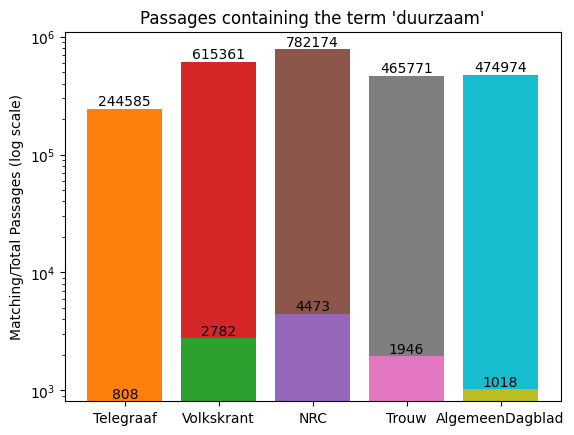

In [13]:
import matplotlib.pyplot as plt

assert text_widget.value.strip(), "No search term provided"

fig, ax = plt.subplots()

ax.set_title(f"Passages containing the term '{text_widget.value}'")

scale = "log"
ax.set_ylabel(f"Matching/Total Passages ({scale} scale)")
ax.set_yscale(scale)

for collection in collection_selector.value:
    doc_freq = db.doc_frequency(
        text_widget.value, collection, metadata_not=metadata_not
    )
    total_count = db.doc_frequency("", collection, metadata_not=metadata_not)

    bar_matches = ax.bar(collection, doc_freq, label=f"{collection} - Matches")
    ax.bar_label(bar_matches, fmt="%d", label_type="edge")

    bar_total = ax.bar(
        collection,
        total_count - doc_freq,
        bottom=doc_freq,
        label=f"{collection} - Total",
    )
    ax.bar_label(bar_total, fmt="%d", label_type="edge")

# Frequencies Per Year

In [14]:
start = 1850
end = 2024

year_range = widgets.SelectionRangeSlider(
    options=[str(i) for i in range(start, end)], index=(100, 150), description="Years"
)
year_range

SelectionRangeSlider(description='Years', index=(100, 150), options=('1850', '1851', '1852', '1853', '1854', '…

In [15]:
normalize = widgets.Checkbox(
    value=True, description="Normalize Frequencies", disabled=False
)
normalize

Checkbox(value=True, description='Normalize Frequencies')

In [16]:
import pandas as pd
from tqdm import tqdm

doc_freqs = pd.DataFrame(
    index=range(int(year_range.value[0]), int(year_range.value[1]))
)

for collection in tqdm(collection_selector.value, unit="collection"):
    doc_freqs[collection] = [
        db.doc_frequency(
            text_widget.value,
            collection,
            {"year": str(year)},
            metadata_not=metadata_not,
            normalize=normalize.value,
        )
        for year in doc_freqs.index
    ]

100%|██████████| 5/5 [00:30<00:00,  6.04s/collection]


<Axes: title={'center': "Normalized Frequency of 'duurzaam' (Rolling Average over 5 years)"}, xlabel='Year', ylabel='Normalized Frequency'>

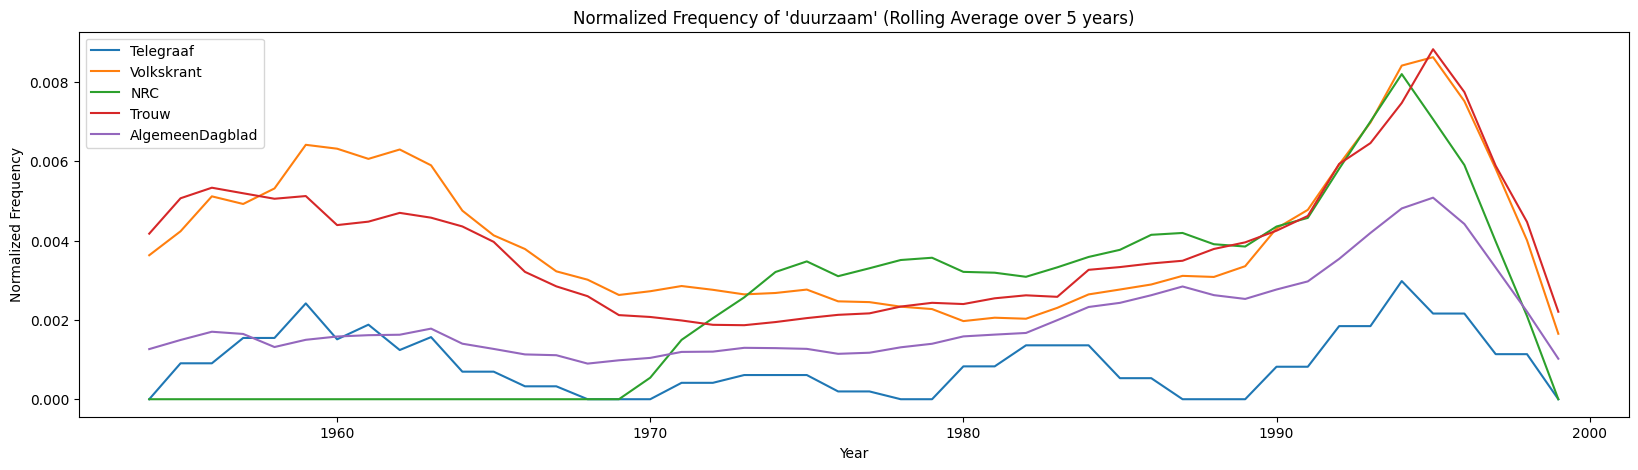

In [17]:
window_size = 5
_prefix = "Normalized " if normalize.value else ""

doc_freqs.rolling(window_size).mean().plot(
    figsize=(20, 5),
    title=f"{_prefix}Frequency of '{text_widget.value}' (Rolling Average over {window_size} years)",
    xlabel="Year",
    ylabel=f"{_prefix}Frequency",
)

# Create Corpus

In [18]:
%autoreload now

In [19]:
collections = [
    db.get_corpus(
        collection,
        [text_widget.value],
        year_from=year_range.value[0],
        year_to=year_range.value[1],
        include_embeddings=True,
        metadata_not=metadata_not,
    )
    for collection in collection_selector.value
]

## Expand Corpus with Close Passages

In [20]:
distance_widget = widgets.FloatSlider(
    value=0.4, min=0, max=1, step=0.01, description="Distance Threshold"
)

distance_widget

FloatSlider(value=0.4, description='Distance Threshold', max=1.0, step=0.01)

In [21]:
from tempo_embeddings.text.year_span import YearSpan

neighbours = {
    collection: db.neighbour_passages(
        collection,
        k=len(collection),  # at most, double the collection
        collections=collection_selector.value,
        distance=distance_widget.value,
        year_span=YearSpan(year_range.value[0], year_range.value[1]),
        metadata_not=metadata_not,
    )
    for collection in tqdm(collections, unit="collection", desc="Getting Neighbours")
}

Getting Neighbours: 100%|██████████| 5/5 [00:06<00:00,  1.36s/collection]


In [22]:
print(
    "\t".join(
        [
            "Collection Label",
            "Size",
            f"Neighbours with Distance < {distance_widget.value}",
        ]
    )
)
for collection in collections:
    print(
        "\t".join(
            [collection.label, str(len(collection)), str(len(neighbours[collection]))]
        )
    )

Collection Label	Size	Neighbours with Distance < 0.4
Telegraaf: duurzaam	461	145
Volkskrant: duurzaam	2189	284
NRC: duurzaam	1894	319
Trouw: duurzaam	1859	320
AlgemeenDagblad: duurzaam	1018	172


In [23]:
import random

for collection in collections:
    print(f"\n{collection.label} - Random Sample of Neighbours:")
    for passage in random.sample(neighbours[collection], 10):
        print(passage.text)


Telegraaf: duurzaam - Random Sample of Neighbours:
Zegwaard 'bepaald niet milieuvriendelijk' Door een onzer redacteuren den haag, 25 nov.
'Er zijn volop gelijkheden om, op basis van het ons land aanwezige potentieel "menskracht, kennis en kapitaal, euwe minder milieubelastende weBen in te slaan.' h het begrip duurzaam„:. °P veel manieren kan worden gelegd, wordt in de brief gepleit Cf°J een strakke definitie.
Contractarbeid betekent geen duurzaam inkomen.
Laat men dit na, dan is het gevolg, ofwel een duurzaam hoog prijspeil, ofwel voortdurende ondersteuning van de landbouw, ofwel een verpaupering der agrariërs.
En dat op den duur zoveel mogelijk milieuvriendelijk materiaal wordt gebruikt.
Werkgevers De werkgevers hebben wel erkend, dat er maatregelen moeten worden genomen om duurzaam bezit te brengen onder brede lagen van de bevolking.
Daarvan is sprake als er een gezamenlijk huishouden wordt gevoerd, als dat duurzaam is en als dat naar buiten toe wordt uitgedragen.
Relatief milieuvri

## Cluster Corpus

In [41]:
%autoreload now

In [42]:
from tempo_embeddings.text.corpus import Corpus

corpus = sum(collections, Corpus())

In [43]:
if all(
    (
        passage.metadata["provenance"].startswith("NRC_")
        for passage in corpus.passages
        if "newspaper" not in passage.metadata
    )
):
    fillna_newspaper = "NRC"
else:
    # This happens if we combine newspapers and non-newspapers here
    raise RuntimeError(
        "Cannot determine how to fill empty 'newspaper' metadata fields."
    )

In [44]:
corpus.compress_embeddings(recompute=True)

array([[9.05492  , 2.6552618],
       [8.869743 , 2.2570543],
       [8.547363 , 4.420137 ],
       ...,
       [6.5244765, 6.605723 ],
       [6.8752184, 3.1206505],
       [7.355305 , 4.6475735]], dtype=float32)

In [45]:
clusters = corpus.cluster(
    use_2d_embeddings=True,
    max_clusters=50,
    cluster_selection_method="leaf",
    min_cluster_size=20,
    min_samples=5,
)
len(clusters)

29

In [46]:
from tempo_embeddings.settings import STOPWORDS

for cluster in clusters:
    cluster.set_topic_label(exclude_words=STOPWORDS | {text_widget.value})

/Users/carstenschnober/Documents/SemanticsOfSustainability/workspace/tempo-embeddings/.venv/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Text(0.5, 1.0, "Cluster Sizes for 'duurzaam'")

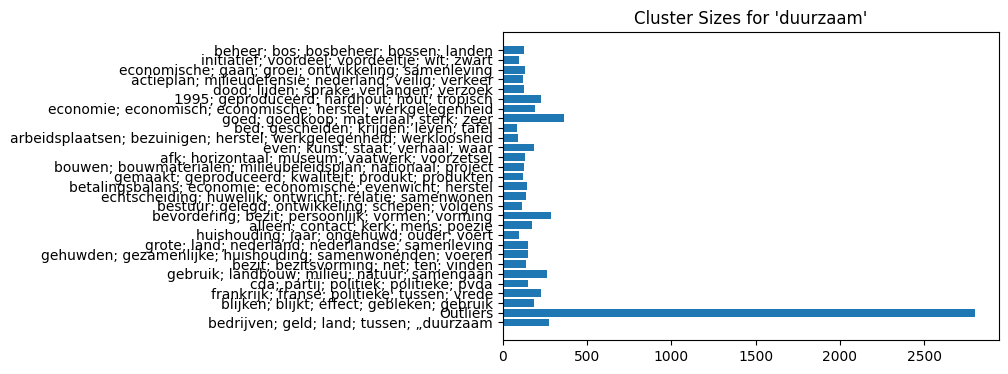

In [47]:
fig, ax = plt.subplots()
fig.set_figheight(len(clusters) // 6)

ax.barh(
    [cluster.label for cluster in clusters],
    [len(cluster) for cluster in clusters],
)
ax.set_title(f"Cluster Sizes for '{text_widget.value}'")

In [48]:
import os

from bokeh.io import output_notebook
from bokeh.plotting import show

from tempo_embeddings.visualization.bokeh import BokehInteractiveVisualizer

try:
    del visualizer
except NameError:
    pass

visualizer = BokehInteractiveVisualizer(*clusters, width=1500, height=500)

os.environ["BOKEH_ALLOW_WS_ORIGIN"] = "*"

output_notebook()

show(visualizer.create_document)

Loading BokehJS ...

# Cluster-based Statistics

In [49]:
import random

cluster_selector = widgets.Select(
    options=[cluster.label for cluster in clusters],
    value=random.choice(clusters).label,
    description="Choose a Cluster:",
    rows=len(clusters),
    layout=widgets.Layout(width="auto"),
)
cluster_selector

Select(description='Choose a Cluster:', index=8, layout=Layout(width='auto'), options=('bedrijven; geld; land;…

<Axes: title={'center': "Relative frequency of cluster 'economie; economisch; economische; herstel; werkgelegenheid' by newspaper"}, xlabel='newspaper', ylabel='Sentence Count'>

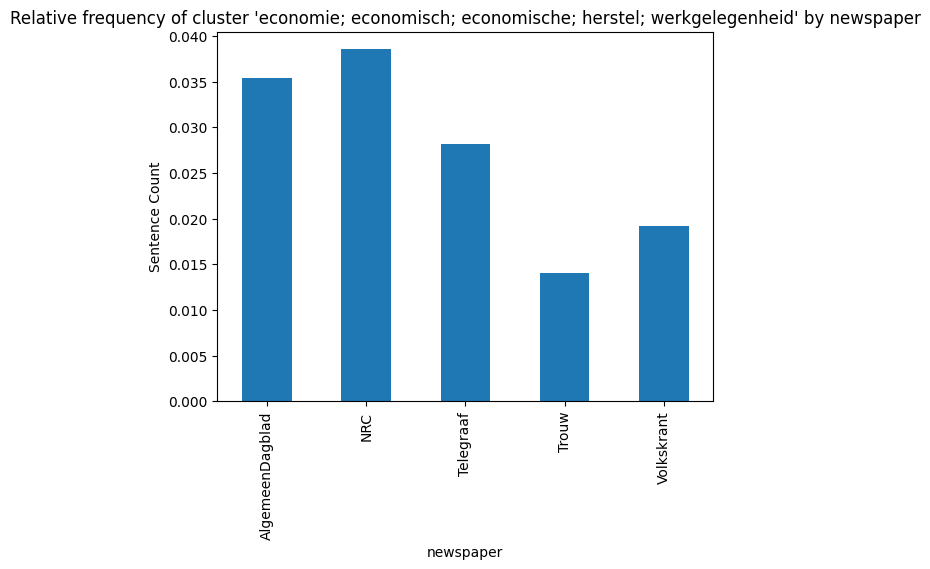

In [66]:
from tempo_embeddings.text.subcorpus import Subcorpus

field = "newspaper"

subcorpus: Subcorpus = next(
    cluster for cluster in clusters if cluster.label == cluster_selector.value
)

corpus_counts = pd.Series(
    [
        newspaper
        for newspaper, passages in corpus.groupby(
            "newspaper", default_value=fillna_newspaper
        )
        for passage in passages
    ]
).value_counts()

cluster_counts = (
    pd.Series(
        p.metadata.get(field, fillna_newspaper) for p in subcorpus.passages
    ).value_counts()
    / corpus_counts  # Normalize by number of passages in each newspaper in the corpus
)

cluster_counts.plot(
    kind="bar",
    title=f"Relative frequency of cluster '{cluster_selector.value}' by {field}",
    xlabel=field,
    ylabel="Sentence Count",
)

<Axes: title={'center': "year distribution in cluster 'gehuwd; gehuwden; gescheiden; samenwonen; samenwonenden' (Rolling average over 5 years)"}, xlabel='year', ylabel='Sentence Count'>

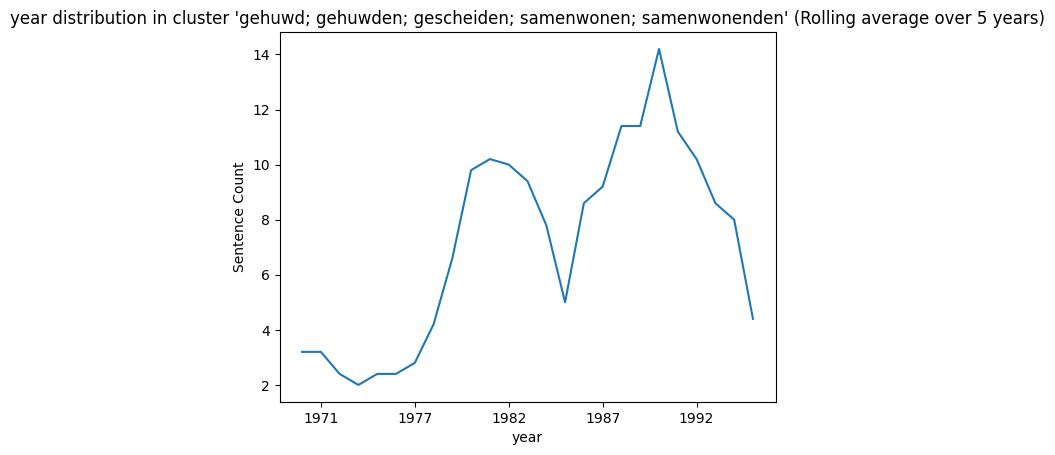

In [84]:
field = "year"


pd.Series(
    p.metadata.get(field) for p in subcorpus.passages
).value_counts().sort_index().rolling(window_size).mean().plot(
    # kind="bar",
    title=f"{field} distribution in cluster '{cluster_selector.value}' (Rolling average over {window_size} years)",
    xlabel=field,
    ylabel="Sentence Count",
)

In [85]:
from tempo_embeddings.settings import OUTLIERS_LABEL

field = "year"

cluster_years = []
for cluster in clusters:
    if cluster.label != OUTLIERS_LABEL:
        collection_sizes = pd.Series(
            (p.metadata.get(field) for p in cluster.passages)
        ).value_counts()
        collection_sizes.name = cluster.label
        cluster_years.append(collection_sizes)

<Axes: title={'center': 'Yearly Distribution of Clusters'}>

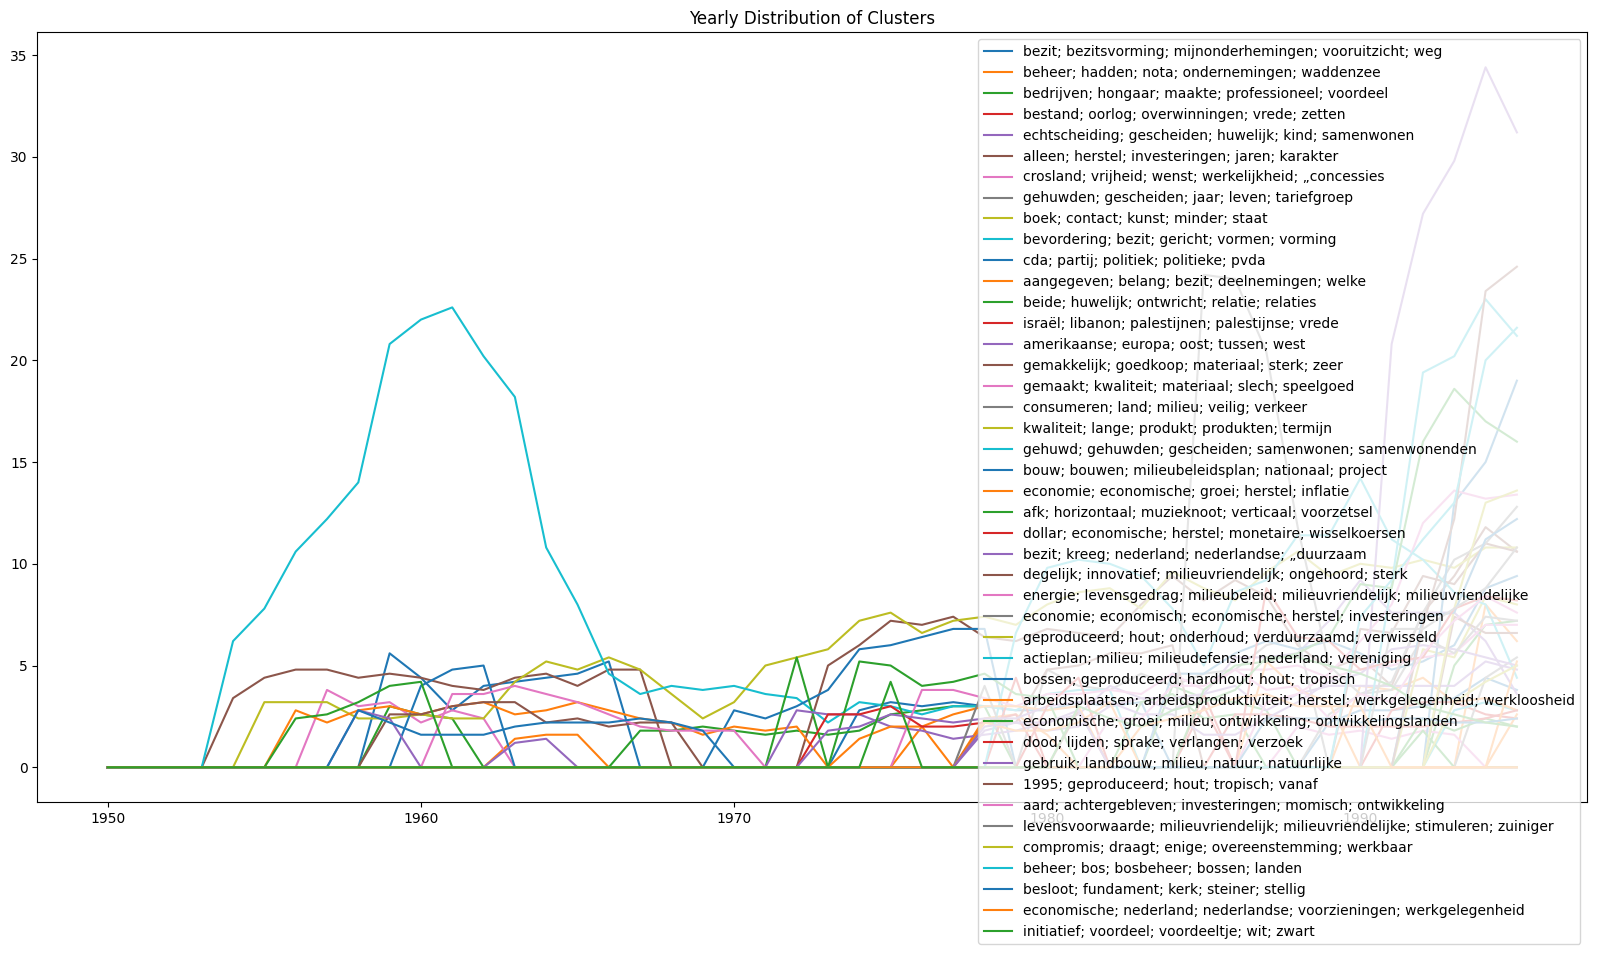

In [86]:
pd.concat(cluster_years, axis=1).sort_index().rolling(window_size).mean().fillna(
    0
).plot(kind="line", figsize=(20, 10), title="Yearly Distribution of Clusters")